In [1]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [2]:
# only recorded conjunctions after this date
start_date = "2023-01-06"
end_date = "2023-01-20"
high_risk = 10e-4

In [3]:
input_conjunctions_file_prefix = "./cleaned/starlink-conjunctions/"
input_tle_file_prefix = "./propagated/STARLINK"
output_dir = "./images/conjunctions/"

In [4]:
# find all files with the given prefix
files = glob.glob(input_tle_file_prefix + "*")

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

conjuncted_satellites = set()


In [5]:

for f in files:
    sat_name = os.path.basename(f).split(".")[0]

    # read conjunctions
    conjunction_file = input_conjunctions_file_prefix + f"{sat_name}.csv"

    try:
        conjunctions = pd.read_csv(conjunction_file)
    except:
        print(f"Could not read conjunctions for {sat_name} (file exists: {os.path.exists(conjunction_file)})")
        continue

    conjunctions = conjunctions[conjunctions['date'] >= start_date]
    conjunctions = conjunctions[conjunctions['date'] <= end_date]

    conjunctions['date'] = pd.to_datetime(conjunctions['date'])
    conjunctions['date_tca'] = pd.to_datetime(conjunctions['date_tca'])

    important_conjunctions = conjunctions[conjunctions['probability'] > high_risk]

    if len(important_conjunctions) == 0:
        # print(f"No important conjunctions for {sat_name}")
        continue

    conjuncted_satellites.add(sat_name)


Could not read conjunctions for STARLINK BE (file exists: False)
Could not read conjunctions for STARLINK Q (file exists: False)
Could not read conjunctions for STARLINK BD (file exists: False)
Could not read conjunctions for STARLINK-5257 (file exists: False)
Could not read conjunctions for STARLINK-5296 (file exists: False)
Could not read conjunctions for STARLINK AJ (file exists: False)
Could not read conjunctions for STARLINK BF (file exists: False)
Could not read conjunctions for STARLINK S (file exists: False)
Could not read conjunctions for STARLINK D (file exists: False)
Could not read conjunctions for STARLINK-5320 (file exists: False)
Could not read conjunctions for STARLINK AK (file exists: False)
Could not read conjunctions for STARLINK-3816 (file exists: False)
Could not read conjunctions for STARLINK-5287 (file exists: False)
Could not read conjunctions for STARLINK BC (file exists: False)
Could not read conjunctions for STARLINK-2107 (file exists: False)
Could not read c

In [7]:
# next, plot distance distribution for all the satellites
distances = []

for f in files:
    sat_name = os.path.basename(f).split(".")[0]

    if not sat_name in conjuncted_satellites:
        continue

    # read input file
    sat_df = pd.read_csv(f)
    sat_df = sat_df[sat_df['date'] >= start_date]
    sat_df = sat_df[sat_df['date'] <= end_date]
    sat_df['date'] = pd.to_datetime(sat_df['date'])

    df_distance = sat_df[["distance_ground"]].copy()
    df_distance["satellite"] = sat_name

    distances.append(df_distance)

df = pd.concat(distances)
df.rename(columns={"distance_ground": "altitude"}, inplace=True)
df["altitude"] = df["altitude"] / 1000
df.reset_index(drop=True, inplace=True)

[(580.0, 500.0)]

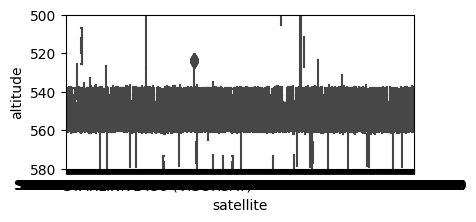

In [14]:
# now plot!
g = sns.boxplot(data=df, x="satellite", y="altitude", color="#4477AA")
# g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylim=(580, 500))

In [17]:
deviation = df.groupby("satellite").agg({"altitude": ["mean", "std", "max", "min"]})
deviation.columns = ["mean", "std", "max", "min"]
deviation.reset_index(inplace=True)
deviation["diff"] = deviation.apply(lambda x: max(x["max"] - x["mean"], x["mean"] - x["min"]), axis=1)
deviation.head()

,satellite,mean,std,max,min,diff
0,STARLINK-1012,554.219274,4.921800,560.635318,545.881390,8.337883
1,STARLINK-1049,554.213988,4.995999,560.587490,545.863296,8.350692
2,STARLINK-1106,552.281520,5.348682,559.996197,541.994669,10.286851
3,STARLINK-1107,554.224400,5.171469,561.023412,545.520364,8.704037
4,STARLINK-1109,554.199269,4.995380,560.496089,545.786484,8.412785


<AxesSubplot: xlabel='satellite', ylabel='diff'>

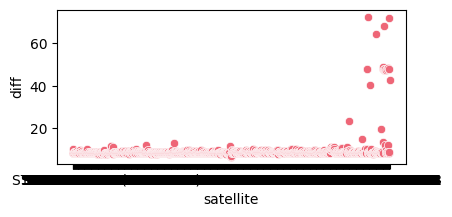

In [19]:
sns.scatterplot(data=deviation, x="satellite", y="diff", color="#EE6677")

In [ ]:

# save figure
# plt.savefig(os.path.join(output_dir, "altitude_distribution.png"), dpi=100, bbox_inches="tight")
# plt.close(g.get_figure())
